**Подключение библиотек и скриптов**

In [212]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [213]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [214]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [215]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
    def fit(self, df):
        """Сохранение статистик"""
        self.medians = df[['LifeSquare', 'Healthcare_1']].median()
        
    def transform_0(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        # 2. Выбросы (outliers)
        
        # 
        df.loc[(df['Square'] < 10), 'Square'] = df['Square'].median()
        
        # 
        df.loc[(df['LifeSquare'] < 10), 'LifeSquare'] = df['LifeSquare'].median()
        
        # 
        df.loc[(df['LifeSquare'] > df['Square']), 'LifeSquare'] = df['Square']
        
        # 
        df.loc[((df['KitchenSquare'] > df['LifeSquare']*0.3) | (df['KitchenSquare'] < 3)), 'KitchenSquare'] = df['KitchenSquare'].median()
        
        #
        df.loc[(df['HouseYear'] > 2020), 'HouseYear'] = 2020
        
        #
        df.loc[((df['Rooms'] > 6) | (df['Rooms'] < 1)), 'Rooms'] = df['Rooms'].median()
        
        #
        df.loc[(df['HouseFloor'] < 1), 'HouseFloor'] = 1
        
        #
        df.loc[(df['HouseFloor'] > 50), 'HouseFloor'] = df['HouseFloor'].median()
        
        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df
    
    def transform_1(self, df):
        # 3. Новые фичи (features)
        
        #
        #df['SquareMeterPrice'] = df['Price'] / df['Square']
        
        df['Price'] = df['Price'] // 10000 * 10000
        
        return df

In [216]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [242]:
pipe = DataPipeline()

df = pd.read_csv(DATASET_PATH)
df = reduce_mem_usage(df)

pipe.fit(df)
df = pipe.transform_0(df)
df = pipe.transform_1(df)

X_final = pd.read_csv(TEST_DATASET_PATH)
X_final = reduce_mem_usage(X_final)
pipe.fit(X_final)
X_final = pipe.transform_0(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [218]:
df.head().T

,0,1,2,3,4
Id,14038,15053,4765,5809,10783
DistrictId,35,41,53,58,99
Rooms,2,3,2,2,1
Square,47.9816,65.6836,44.948,53.353,39.6492
LifeSquare,29.4428,40.0495,29.1976,52.7315,23.7762
KitchenSquare,6,8,6,9,7
Floor,7,7,8,8,11
HouseFloor,9,9,12,17,12
HouseYear,1969,1978,1968,1977,1976
Ecology_1,0.0890397,6.99893e-05,0.0496373,0.437885,0.0123389


In [219]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,16798.000000
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.888800,0.812096,1.000000,1.000000,2.000000,2.000000,6.000000
Square,10000.0,56.374352,20.979980,13.784864,41.794393,52.513580,65.900627,641.065186
LifeSquare,10000.0,35.959919,16.629345,10.523869,27.619654,32.781261,41.178370,638.163208
KitchenSquare,10000.0,6.707000,1.786972,3.000000,6.000000,6.000000,7.000000,30.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,12.608700,6.532967,1.000000,9.000000,13.000000,17.000000,48.000000
HouseYear,10000.0,1984.872400,18.416347,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867


In [243]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
                 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

target_name = 'Price'

In [244]:
df = df[feature_names + [target_name]]
df.head().T

,0,1,2,3,4
DistrictId,35.000000,41.000000,53.000000,58.000000,99.000000
Rooms,2.000000,3.000000,2.000000,2.000000,1.000000
Square,47.981560,65.683640,44.947952,53.352982,39.649193
LifeSquare,29.442751,40.049541,29.197611,52.731510,23.776169
KitchenSquare,6.000000,8.000000,6.000000,9.000000,7.000000
Floor,7.000000,7.000000,8.000000,8.000000,11.000000
HouseFloor,9.000000,9.000000,12.000000,17.000000,12.000000
HouseYear,1969.000000,1978.000000,1968.000000,1977.000000,1976.000000
Ecology_1,0.089040,0.000070,0.049637,0.437885,0.012339
Social_1,33.000000,46.000000,34.000000,23.000000,35.000000


In [245]:
X_final = X_final[feature_names + ['Id']]
X_final.head().T

,0,1,2,3,4
DistrictId,58.000000,74.000000,190.000000,47.000000,27.000000
Rooms,2.000000,2.000000,1.000000,2.000000,1.000000
Square,49.882645,69.263184,13.597818,73.046608,47.527111
LifeSquare,33.432781,32.925087,13.597818,51.940842,43.387569
KitchenSquare,6.000000,6.000000,6.000000,9.000000,6.000000
Floor,6.000000,6.000000,2.000000,22.000000,17.000000
HouseFloor,14.000000,1.000000,5.000000,22.000000,17.000000
HouseYear,1972.000000,1977.000000,1909.000000,2007.000000,2017.000000
Ecology_1,0.310199,0.075779,0.000000,0.101872,0.072158
Social_1,11.000000,6.000000,30.000000,23.000000,2.000000


In [246]:
feature_names_for_stand = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [247]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min)
# StandardScaler() Для каждой фичи х делает: (x - mean) / std
# RobustScaler() Для каждой фичи х делает: (x - median) / (q75 - q25)

scaler = StandardScaler()
stand_features_0 = scaler.fit_transform(df[feature_names_for_stand])
stand_features_1 = scaler.fit_transform(X_final[feature_names_for_stand])

In [248]:
df[feature_names_for_stand] = pd.DataFrame(stand_features_0, columns=feature_names_for_stand)
df.head().T

,0,1,2,3,4
DistrictId,-0.353348,-0.215687,0.059635,0.174352,1.115034
Rooms,0.136936,1.368379,0.136936,0.136936,-1.094506
Square,-0.400058,0.443745,-0.544661,-0.144019,-0.797236
LifeSquare,-0.391927,0.245940,-0.406670,1.008604,-0.732702
KitchenSquare,-0.395661,0.723606,-0.395661,1.283240,0.163973
Floor,-0.291306,-0.291306,-0.100498,-0.100498,0.471924
HouseFloor,-0.552411,-0.552411,-0.093178,0.672209,-0.093178
HouseYear,-0.861908,-0.373187,-0.916210,-0.427489,-0.481792
Ecology_1,-0.250529,-0.998053,-0.581588,2.680470,-0.894969
Social_1,0.474169,1.215681,0.531208,-0.096225,0.588247


In [249]:
X_final[feature_names_for_stand] = pd.DataFrame(stand_features_1, columns=feature_names_for_stand)
X_final.head().T

,0,1,2,3,4
DistrictId,0.152140,0.514336,3.140252,-0.096869,-0.549613
Rooms,0.113827,0.113827,-1.120741,0.113827,-1.120741
Square,-0.350299,0.671196,-2.262773,0.870609,-0.474453
LifeSquare,-0.175168,-0.210000,-1.536004,1.094633,0.507810
KitchenSquare,-0.403019,-0.403019,-0.403019,1.332138,-0.403019
Floor,-0.480057,-0.480057,-1.209628,2.438224,1.526261
HouseFloor,0.209683,-1.751096,-1.147780,1.416316,0.662170
HouseYear,-0.667299,-0.398066,-4.059631,1.217331,1.755796
Ecology_1,1.585280,-0.367283,-0.998468,-0.149940,-0.397445
Social_1,-0.794834,-1.080052,0.288994,-0.110311,-1.308227


In [231]:
X = df[feature_names]
y = df[target_name]

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [233]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

In [234]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [235]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42
                         )

In [97]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 2min 12s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [98]:
gs.best_params_

{'max_depth': 3, 'n_estimators': 400}

In [99]:
gs.best_score_

0.7420598822758511

R2:	0.837
RMSE:	37516.297
MSE:	1407472555.123


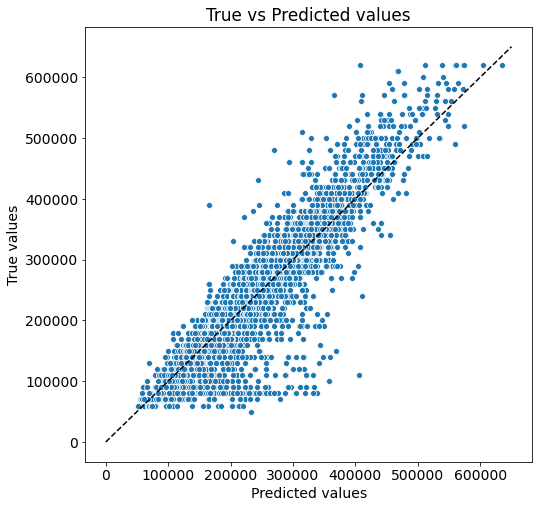

In [236]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=3,
                                        min_samples_leaf=10,
                                        random_state=42,  
                                        n_estimators=400)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.73
RMSE:	48280.811
MSE:	2331036706.311


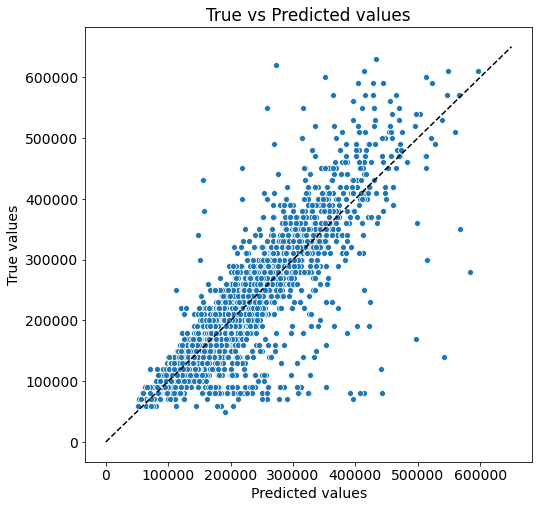

In [237]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=False)

In [167]:
final_model.feature_importances_

array([7.01369486e-02, 4.30821911e-02, 4.40787576e-01, 1.37032693e-02,
       3.53279354e-02, 1.43549443e-02, 1.38971323e-02, 2.93185288e-02,
       4.37175195e-02, 1.05569139e-01, 6.24060749e-02, 8.47360231e-02,
       2.55714418e-02, 4.74912468e-03, 1.14603249e-02, 8.60394528e-05,
       1.69773043e-04, 2.44260952e-04, 5.59595708e-04, 1.22157908e-04,
       0.00000000e+00])

In [195]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [196]:
feature_importances.head(5)

,feature_name,importance
2,Square,0.440788
9,Social_1,0.105569
11,Social_3,0.084736
0,DistrictId,0.070137
10,Social_2,0.062406


In [170]:
feature_importances.tail(5)

,feature_name,importance
17,Ecology_3_A,0.000244
16,Ecology_2_B,0.000170
19,Shops_2_A,0.000122
15,Ecology_2_A,0.000086
20,Shops_2_B,0.000000


In [171]:
feature_final = feature_importances.loc[feature_importances['importance'] > 0.01]

In [ ]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [250]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)
X_final = X_final[feature_names]

In [251]:
X_final.T

Id,725,15856,5480,15664,14275,7633,13329,5502,4220,11538,...,15706,2105,7220,14562,6836,8180,4695,5783,4780,12504
DistrictId,0.152140,0.514336,3.140252,-0.096869,-0.549613,0.038954,-0.640162,-0.436427,1.012354,-1.024995,...,0.967080,0.287963,1.012354,1.397187,-0.277967,-0.911809,-1.138181,-0.889172,0.242689,-0.481702
Rooms,0.113827,0.113827,-1.120741,0.113827,-1.120741,-1.120741,0.113827,0.113827,1.348396,1.348396,...,0.113827,0.113827,1.348396,0.113827,0.113827,1.348396,-1.120741,1.348396,0.113827,0.113827
Square,-0.350299,0.671196,-2.262773,0.870609,-0.474453,-0.835576,0.609863,-0.439309,0.830051,1.248667,...,-0.461309,-0.581653,1.246722,-0.521849,-0.600731,0.558967,-0.860725,1.123371,1.305898,0.212248
LifeSquare,-0.175168,-0.210000,-1.536004,1.094633,0.507810,-0.210000,1.979826,-0.214627,0.684900,0.800951,...,-0.553329,-0.271920,0.867299,-0.612478,-0.357132,1.017034,-0.972785,0.843650,-0.210000,-0.210000
KitchenSquare,-0.403019,-0.403019,-0.403019,1.332138,-0.403019,-0.403019,-0.403019,-0.403019,1.332138,1.332138,...,-0.403019,-0.403019,1.910523,-0.981405,-0.403019,-0.403019,-0.403019,1.332138,-0.403019,-0.403019
Floor,-0.480057,-0.480057,-1.209628,2.438224,1.526261,2.255831,-1.209628,-0.662450,1.526261,0.796691,...,-0.115272,-0.844842,0.249513,-0.480057,-1.209628,-0.662450,0.614298,2.620616,-0.844842,0.249513
HouseFloor,0.209683,-1.751096,-1.147780,1.416316,0.662170,1.265487,0.662170,0.209683,0.662170,0.662170,...,-0.544463,-0.544463,0.662170,-1.147780,-1.147780,-0.544463,0.662170,1.416316,-1.751096,0.662170
HouseYear,-0.667299,-0.398066,-4.059631,1.217331,1.755796,-0.398066,-0.398066,-0.667299,0.678865,1.594256,...,-0.774992,-0.559606,1.001944,-0.828838,-1.044225,-0.613452,1.755796,0.248093,-0.398066,-0.398066
Ecology_1,1.585280,-0.367283,-0.998468,-0.149940,-0.397445,-0.585024,-0.367283,0.131402,-0.655997,1.027261,...,1.357045,0.131402,-0.655997,1.562521,2.573360,-0.997055,-0.939144,-0.242173,-0.397445,-0.997818
Social_1,-0.794834,-1.080052,0.288994,-0.110311,-1.308227,0.517169,-1.080052,1.201692,1.600997,-1.137096,...,0.460125,1.201692,1.600997,0.288994,0.003776,0.631256,-1.365270,2.798913,-1.308227,-0.167355


In [252]:
y_pred_final = final_model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,Price
0,725,150580.839612
1,15856,210501.338353
2,5480,205914.901929
3,15664,360163.799788
4,14275,130422.135361
